In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torchconvquality import measure_layer_quality
import tensorflow as tf
import tensorflow_hub as hub
import onnx, onnx.numpy_helper

/home/dhoof/.conda/envs/tf2onnx/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-10-14 01:15:58.954508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2022-10-14 01:15:58.955018: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
v_tab_hub_modules=[
    "https://tfhub.dev/vtab/jigsaw/1",
    "https://tfhub.dev/vtab/semi-rotation-10/1",
    "https://tfhub.dev/vtab/sup-exemplar-100/1",    
    "https://tfhub.dev/vtab/cond-biggan/1",
    "https://tfhub.dev/vtab/relative-patch-location/1",
    "https://tfhub.dev/vtab/uncond-biggan/1",
    "https://tfhub.dev/vtab/sup-100/1",
    "https://tfhub.dev/vtab/exemplar/1",
    "https://tfhub.dev/vtab/semi-exemplar-10/1",    
    "https://tfhub.dev/vtab/vae/1",
    "https://tfhub.dev/vtab/sup-rotation-100/1",
    "https://tfhub.dev/vtab/rotation/1"    
]

In [3]:
# module_paths={}
# for hub_module in v_tab_hub_modules:
#     module_path = hub.resolve(hub_module)
#     module_paths[hub_module.split("/")[4]] = module_path

In [4]:
# module_paths

{'jigsaw': '/tmp/tfhub_modules/9497e027f93c236c31c081a3d83a3cc198bd9d09',
 'semi-rotation-10': '/tmp/tfhub_modules/89aa2677e5a3252d15fa938092d918686a4b887b',
 'sup-exemplar-100': '/tmp/tfhub_modules/15d2c4fa8da9370cf479cad685266e0bb29ef242',
 'cond-biggan': '/tmp/tfhub_modules/75e75ce01696c28c0f273e93578475917a107290',
 'relative-patch-location': '/tmp/tfhub_modules/3b44a30031b387a89972ccd8caeb96f7ef2ac418',
 'uncond-biggan': '/tmp/tfhub_modules/2fba7fda94c10e21765a3d11a96efe24093d5029',
 'sup-100': '/tmp/tfhub_modules/079526936ad25fbd75b37650278282fcdb9ca416',
 'exemplar': '/tmp/tfhub_modules/45a92ade0a81d0ec4cd969421a02a4f0948c91c2',
 'semi-exemplar-10': '/tmp/tfhub_modules/b831a4a9ac75f88543145a22247fbe7b8b210588',
 'vae': '/tmp/tfhub_modules/a39e99fd74357bf04b95606aa20d6937c0b050e1',
 'sup-rotation-100': '/tmp/tfhub_modules/9a9c2d4353179138851420afe700e7fa4f1bea44',
 'rotation': '/tmp/tfhub_modules/dc09ac98e9b8bed2126b6d588343bdf53f5b49ed'}

In [5]:
# for name, module_path in module_paths.items():
#     onnx_path = f"onnx/{name}.onnx"    
#     # print(onnx_path)
#     if not os.path.exists("convert_commands.txt"):
#         with open("convert_commands.txt","a") as f:
#             f.write(f"python -m tf2onnx.convert --saved-model {module_path} --output {onnx_path} --opset 16 --tag train\n")

In [6]:
class ConvolutionCalculation:

    def __init__(self, operators=["Conv", "ConvTranspose", "ConvInteger", "QLinearConv"]):
        self.__operators = operators

    def get_operators(self):
        return self.__operators

    @staticmethod
    def __check_strides(attribute) -> bool:
        """
        Returns True if strides in attribute affects output size
        :param attribute: given attribute to check
        :return: bool
        """
        return all(i > 0 for i in attribute.ints) and attribute.name == "strides"

    @staticmethod
    def __check_padding(attribute) -> bool:
        """
        Returns True if padding in attribute affects output size
        :param attribute: given attribute to check
        :return: bool
        """
        return all(i > 0 for i in attribute.ints) and attribute.name == "pads"

    @staticmethod
    def __check_kernel_size(attribute) -> bool:
        """
        Returns True if kernel size in attribute affects output size
        :param attribute: given attribute to check
        :return: bool
        """
        return all(i > 0 for i in attribute.ints) and attribute.name == "kernel_shape"

    def filter(self, node) -> bool:
        """
        Filter method to reduce to only necessary operations
        :param node: node to check
        :return: bool
        """
        return (node.op_type in self.__operators) and any(
            [self.__check_strides(attribute) or self.__check_padding(attribute) or self.__check_kernel_size(attribute)
             for
             attribute in node.attribute])

    def find_attributes(self, node):
        """
        Returns the padding, kernel size and strides values from the attribute
        :param node: node, which to extract the attribute values from
        :return: (padding_width_top, padding_width_bottom, strides_width, kernel_width,
               padding_height_top, padding_height_bottom, strides_height, kernel_height)
        """
        attributes = list(map(list, zip(*[[attribute.name, attribute.ints] for attribute in node.attribute])))

        padding_width_top, padding_width_bottom, padding_height_top, padding_height_bottom = self.__extract_pads(
            attributes)

        strides_width, strides_height = self.__extract_strides(attributes)
        kernel_width, kernel_height = self.__extract_kernel(attributes)

        return padding_width_top, padding_width_bottom, strides_width, kernel_width, \
               padding_height_top, padding_height_bottom, strides_height, kernel_height

    @staticmethod
    def __extract_pads(attributes) -> tuple:
        """
        Extract the padding from the attributes
        :param attributes: attributes to check
        :return: (padding_width_top, padding_width_bottom, padding_height_top, padding_height_bottom)
        """

        if "pads" not in attributes[0]:
            return 0, 0, 0, 0
        if "pads" in attributes[0] and len(attributes[1][attributes[0].index("pads")]) != 4:
            if len(attributes[1][attributes[0].index("pads")]) == 2:
                # Sometime symmetries are found: [1,1,2,2] => [1,2]
                return attributes[1][attributes[0].index("pads")][0], attributes[1][attributes[0].index("pads")][0], \
                       attributes[1][attributes[0].index("pads")][1], attributes[1][attributes[0].index("pads")][1]
            return 0, 0, 0, 0
        return attributes[1][attributes[0].index("pads")][0], attributes[1][attributes[0].index("pads")][1], \
               attributes[1][attributes[0].index("pads")][2], attributes[1][attributes[0].index("pads")][3]

    @staticmethod
    def __extract_strides(attributes) -> tuple:
        """
        Extract the strides from the attributes
        :param attributes: attributes to check
        :return: (strides_width, strides_height)
        """
        if "strides" not in attributes[0]:
            return 0, 0, 0, 0
        if "strides" in attributes[0] and len(attributes[1][attributes[0].index("strides")]) != 2:
            if len(attributes[1][attributes[0].index("strides")]) == 1:
                # Sometime symmetries are found: [2,2] => [2]
                return attributes[1][attributes[0].index("strides")][0], \
                       attributes[1][attributes[0].index("strides")][0]

        return attributes[1][attributes[0].index("strides")][0], attributes[1][attributes[0].index("strides")][1]

    @staticmethod
    def __extract_kernel(attributes) -> tuple:
        """
        Extract the kernel shape from the attributes
        :param attributes: attributes to check
        :return: (kernel_width, kernel_height)
        """
        if "kernel_shape" not in attributes[0]:
            return 0, 0, 0, 0
        if "kernel_shape" in attributes[0] and len(attributes[1][attributes[0].index("kernel_shape")]) != 2:
            if len(attributes[1][attributes[0].index("kernel_shape")]) == 1:
                # Sometime symmetries are found: [2,2] => [2]
                return attributes[1][attributes[0].index("kernel_shape")][0], \
                       attributes[1][attributes[0].index("kernel_shape")][0]

        return attributes[1][attributes[0].index("kernel_shape")][0], \
               attributes[1][attributes[0].index("kernel_shape")][1]

In [7]:
class ConvolutionLayer:
    def __init__(self, onnx_model, node, conv_calc):
        self.node = node
        self.layer_name = node.name           
        
        self.attributes = conv_calc.find_attributes(node)      
        
        self.padding = (self.attributes[0],self.attributes[1],self.attributes[4],self.attributes[5])
        self.strides = (self.attributes[2],self.attributes[6])
        self.kernel_size = (self.attributes[3],self.attributes[7])   
        
        self.onnx_weights={}
        for initializer in onnx_model.graph.initializer:
            W = onnx.numpy_helper.to_array(initializer)
            self.onnx_weights[initializer.name] = W        
        
        self.weights = self.get_weights(node)
        
        self.input_channels = self.weights.shape[0]
        self.output_channels = self.weights.shape[1]  
        
    def get_weights(self,node):        
        W=None        
        for input_ in node.input:
            if input_ in self.onnx_weights:
                if len(self.onnx_weights[input_].shape) == 4:                    
                    W = self.onnx_weights[input_]  
        assert W is not None
        return W
        

In [8]:
class Convolution_Quality_Measure:
    def __init__(self, onnx_path):
        self._model = onnx.load(onnx_path)
        self.convolution_layers={}
        
        self.conv_calc = ConvolutionCalculation(operators="Conv")
        
        self.info_dict = {}

        for node in self._model.graph.node:    
            if self.conv_calc.filter(node):                  
                self.convolution_layers[node.name] = ConvolutionLayer(self._model, node, self.conv_calc)   
                
                
    def calc_conv(self, node):    
        conv_ = self.convolution_layers[node.name]

        conv = torch.nn.Conv2d(conv_.input_channels, conv_.output_channels, conv_.kernel_size, conv_.strides, conv_.padding, bias=False)
        with torch.no_grad():
            conv.weight = torch.nn.Parameter(torch.from_numpy(np.array(torch.tensor(conv_.weights))).float())
            # or
            # conv.weight.copy_(torch.from_numpy(numpy_data).float())
        return node.name, conv
                
    def measure_quality(self, **kwargs):
        all_layers=[self.calc_conv(node) for node in self._model.graph.node if node.op_type == "Conv" and self.convolution_layers[node.name].kernel_size == (3,3)]
        
        self.info_dict = {}
        for name, conv_layer in all_layers:
            self.info_dict[name] = measure_layer_quality(conv_layer, **kwargs)

        return self.info_dict        

In [9]:
class QualityMetrics:
    """
    Quality metrics like sparsity and entropy variance. The class also calculates
    the weighted sparsity, entropy variance and the cleaned entropy variance
    """

    def __init__(self, sparsity_eps=0.1):        
        self.sparsity_eps = sparsity_eps

    def calculate_metrics(self, onnx_path) -> dict:
        """
        Calculates quality metrics from given model
        :param model: model to calculate metrics from
        :return: dict of calculated quality metrics
        """
        info_dict=Convolution_Quality_Measure(onnx_path).measure_quality(sparsity_eps=self.sparsity_eps)

        sparsity = []
        variance_entropy = []
        variance_entropy_clean = []
        weights = []

        for key_l, layer in info_dict.items():
            sparsity.append(layer['sparsity'])
            variance_entropy.append(layer['variance_entropy'])
            variance_entropy_clean.append(layer['variance_entropy_clean'])
            weights.append(layer['n'])

        return {
            "sparsity": np.average(sparsity),
            "variance_entropy": np.average(variance_entropy),
            "variance_entropy_clean": np.average(variance_entropy_clean),
            "weighted_sparsity": np.average(a=sparsity, weights=weights),
            "weighted_variance_entropy": np.average(a=variance_entropy, weights=weights),
            "weighted_variance_entropy_clean": np.average(a=variance_entropy_clean, weights=weights),
        }

In [10]:
import glob

quality_metrics={}

for path in glob.glob("onnx/*.onnx"):
    # info_dict=Convolution_Quality_Measure(path).measure_quality()
    quality_metrics[path.split("/")[1].split(".")[0]] = QualityMetrics().calculate_metrics(path)
    # dicts.append(info_dict)

torch.Size([4096, 9])
tensor([3.0618, 2.8127, 2.6335, 2.4087, 1.6524, 1.1196, 0.9458, 0.8983, 0.8346],
       grad_fn=<LinalgSvdBackward0>)
torch.Size([1875, 9])
tensor([2.9406, 2.6644, 2.5184, 2.2247, 1.5238, 1.0221, 0.8686, 0.7990, 0.7417],
       grad_fn=<LinalgSvdBackward0>)
torch.Size([4096, 9])
tensor([3.3004, 2.9088, 2.4988, 2.3203, 1.5784, 1.3478, 1.2959, 1.1993, 1.1781],
       grad_fn=<LinalgSvdBackward0>)
torch.Size([2280, 9])
tensor([3.0745, 2.8045, 2.3696, 2.2035, 1.4643, 1.2497, 1.1947, 1.0949, 1.0723],
       grad_fn=<LinalgSvdBackward0>)
torch.Size([4096, 9])
tensor([2.6721, 2.5134, 2.4581, 2.2535, 2.1616, 1.7746, 1.5751, 1.5424, 1.4246],
       grad_fn=<LinalgSvdBackward0>)
torch.Size([3355, 9])
tensor([2.6362, 2.4779, 2.4182, 2.1988, 2.1238, 1.7354, 1.5388, 1.5028, 1.3815],
       grad_fn=<LinalgSvdBackward0>)
torch.Size([16384, 9])
tensor([5.7664, 3.6452, 3.5554, 3.1568, 2.6731, 2.6378, 2.1375, 1.9762, 1.5950],
       grad_fn=<LinalgSvdBackward0>)
torch.Size([6599, 9

In [43]:
quality_metrics.keys()

dict_keys(['sup-100', 'jigsaw', 'uncond-biggan', 'semi-exemplar-10', 'vae', 'rotation', 'semi-rotation-10', 'relative-patch-location', 'exemplar', 'sup-exemplar-100', 'sup-rotation-100', 'cond-biggan'])

In [3]:
mapping = {
    "Cond-BigGAN": "cond-biggan",
    "Exemplar": "exemplar",
    "Jigsaw": "jigsaw",
    "Rel.Pat.Loc": "relative-patch-location",
    "Rotation": "rotation",
    "Semi-Exemplar-10%": "semi-exemplar-10",
    "Semi-Rotation-10%": "semi-rotation-10",
    "Sup-100%": "sup-100",
    "Sup-Exemplar-100%":"sup-exemplar-100",
    "Sup-Rotation-100%":"sup-rotation-100",
    "Uncond-BigGAN": "uncond-biggan",
    "VAE": "vae",
    "dataset": "finetune_dataset",
    "From-Scratch": "from_scratch"
}

In [4]:
results_df = pd.read_csv("task_adaptation/docs/data/results.csv")

In [180]:
# values_df["from_scratch"].values

In [142]:
values_df=results_df[results_df['train_examples_if_subset'].isin(mapping.keys())].set_index("train_examples_if_subset").transpose().rename(columns=mapping).reset_index()
values_df['index']=values_df['index'].apply(lambda x: x.split('.')[0])
values_df=values_df[(values_df['index']=="1000") | (values_df['index']=="full")]
values_df['finetune_dataset']=values_df['finetune_dataset'].astype(str) +"("+ values_df["index"].astype(str) + ")" 

del values_df['index']

# values_df=values_df.set_index("finetune_dataset")

cols = dict(mapping)
del cols["dataset"]

diff_df=values_df[cols.values()].astype("float32").subtract(values_df["from_scratch"].astype("float32"), axis=0)
diff_df['finetune_dataset']=values_df['finetune_dataset']
del diff_df['from_scratch']
diff_df.head()

train_examples_if_subset,cond-biggan,exemplar,jigsaw,relative-patch-location,rotation,semi-exemplar-10,semi-rotation-10,sup-100,sup-exemplar-100,sup-rotation-100,uncond-biggan,vae,finetune_dataset
0,7.908926,-2.201074,5.758926,5.968927,14.148926,39.988926,34.918926,43.858925,43.538925,40.488926,2.038926,-3.281075,CIFAR-100(1000)
1,23.815792,31.332241,28.486843,30.279606,39.391453,50.312496,49.901318,52.713818,51.990131,53.453953,20.444080,-3.930920,Caltech101(1000)
2,1.556396,3.506470,0.421143,1.913452,4.766846,7.534790,5.764771,4.992676,8.120728,7.821655,0.671387,-3.033447,Camelyon(1000)
3,-26.502157,15.964508,3.971176,4.684509,6.704510,3.491177,2.017845,2.111176,-1.048824,8.477844,5.851177,-2.055489,Clevr-Count(1000)
4,-30.688313,5.671684,0.698353,4.391689,5.738354,2.158356,0.078354,0.918350,0.825016,2.051685,0.565022,6.018353,Clevr-Dist(1000)


In [175]:
df_melt = diff_df.melt(id_vars=["finetune_dataset"], 
        var_name="pretrained_model", 
        value_name="difference")

In [176]:
df_melt.head()

,finetune_dataset,pretrained_model,difference
0,CIFAR-100(1000),cond-biggan,7.908926
1,Caltech101(1000),cond-biggan,23.815792
2,Camelyon(1000),cond-biggan,1.556396
3,Clevr-Count(1000),cond-biggan,-26.502157
4,Clevr-Dist(1000),cond-biggan,-30.688313


In [154]:
metrics_names=[
    "sparsity",
    "variance_entropy",
    "variance_entropy_clean",
    "weighted_sparsity",
    "weighted_variance_entropy",
    "weighted_variance_entropy_clean"
]

In [168]:
value_dicts=[]

for name in metrics_names:
    values = {}
    for key,value in quality_metrics.items():
        values[key]=quality_metrics[key][name]
    value_dicts.append(values)

In [169]:
metrics_df=pd.DataFrame.from_records(value_dicts).transpose().rename(columns=dict(zip(range(0,6),metrics_names))).reset_index().rename(columns={"index":"pretrained_model"})

In [179]:
metrics_df.head()

,pretrained_model,sparsity,variance_entropy,variance_entropy_clean,weighted_sparsity,weighted_variance_entropy,weighted_variance_entropy_clean
0,sup-100,0.579406,0.804152,0.752120,0.742719,0.666446,0.556823
1,jigsaw,0.410002,0.841773,0.817310,0.544757,0.782281,0.747188
2,uncond-biggan,0.445317,0.779466,0.758253,0.631050,0.779448,0.741493
3,semi-exemplar-10,0.550885,0.783764,0.744112,0.784746,0.612717,0.534586
4,vae,0.000061,1.001485,1.001485,0.000198,1.001739,1.001739


In [177]:
df=df_melt.merge(metrics_df)

In [265]:
df

,finetune_dataset,pretrained_model,difference,sparsity,variance_entropy,variance_entropy_clean,weighted_sparsity,weighted_variance_entropy,weighted_variance_entropy_clean
0,CIFAR-100(1000),cond-biggan,7.908926,0.547121,0.751059,0.714191,0.759245,0.669242,0.595055
1,Caltech101(1000),cond-biggan,23.815792,0.547121,0.751059,0.714191,0.759245,0.669242,0.595055
2,Camelyon(1000),cond-biggan,1.556396,0.547121,0.751059,0.714191,0.759245,0.669242,0.595055
3,Clevr-Count(1000),cond-biggan,-26.502157,0.547121,0.751059,0.714191,0.759245,0.669242,0.595055
4,Clevr-Dist(1000),cond-biggan,-30.688313,0.547121,0.751059,0.714191,0.759245,0.669242,0.595055
...,...,...,...,...,...,...,...,...,...
451,Sun397(full),vae,-23.451521,0.000061,1.001485,1.001485,0.000198,1.001739,1.001739
452,dSpr-Loc(full),vae,-0.001358,0.000061,1.001485,1.001485,0.000198,1.001739,1.001739
453,dSpr-Orient(full),vae,-1.665581,0.000061,1.001485,1.001485,0.000198,1.001739,1.001739
454,sNORB-Azim(full),vae,-2.000534,0.000061,1.001485,1.001485,0.000198,1.001739,1.001739


In [183]:
df['finetune_dataset'].unique()

array(['CIFAR-100(1000)', 'Caltech101(1000)', 'Camelyon(1000)',
       'Clevr-Count(1000)', 'Clevr-Dist(1000)', 'DMLab(1000)',
       'DTD(1000)', 'EuroSAT(1000)', 'Flowers102(1000)',
       'KITTI-Dist(1000)', 'Pets(1000)', 'Resisc45(1000)',
       'Retinopathy(1000)', 'SVHN(1000)', 'Sun397(1000)',
       'dSpr-Loc(1000)', 'dSpr-Orient(1000)', 'sNORB-Azim(1000)',
       'sNORB-Elev(1000)', 'CIFAR-100(full)', 'Caltech101(full)',
       'Camelyon(full)', 'Clevr-Count(full)', 'Clevr-Dist(full)',
       'DMLab(full)', 'DTD(full)', 'EuroSAT(full)', 'Flowers102(full)',
       'KITTI-Dist(full)', 'Pets(full)', 'Resisc45(full)',
       'Retinopathy(full)', 'SVHN(full)', 'Sun397(full)',
       'dSpr-Loc(full)', 'dSpr-Orient(full)', 'sNORB-Azim(full)',
       'sNORB-Elev(full)'], dtype=object)

In [5]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rbo

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

sys.path.append("/home/dhoof/master-thesis-automatic-selection/benchmark/metrics-analysis")
sys.path.append("/home/dhoof/pytorch-pretrained-cnns")
# from metrics.loader import CheckpointLoader, MetricsLoader
# from metrics.loader.calculate_metrics import ArchitectureSizeMetrics, QualityMetrics, LatentSpaceMetrics, InformationalMetrics
from metrics.analysis.random_forest_pipeline import RandomForestPipeline
from metrics.analysis.random_forest_pca_pipeline import RandomForestPCAPipeline

In [6]:
import json
vtab_data = None
with open("vtab.json", "r") as f:
    vtab_data=json.loads(f.read())
    
df_full = pd.DataFrame(vtab_data)

In [7]:
pretrained_models=df_full['pretrained_model'].unique()
finetune_datasets=df_full['finetune_dataset'].unique()
target='difference'

In [8]:
features=df_full.loc[:, ~df_full.columns.isin(['finetune_dataset','pretrained_model','difference'])].columns
features

Index(['sparsity', 'variance_entropy', 'variance_entropy_clean',
       'weighted_sparsity', 'weighted_variance_entropy',
       'weighted_variance_entropy_clean'],
      dtype='object')

In [494]:
import random
import sys
def get_finetune_list(section, size, percentage=100, random_seed=0):
    random.seed(random_seed)    
    
    if section == 'natural':
        len_data = 7        
        return random.sample([f'CIFAR-100({size})', f'Caltech101({size})',f'DTD({size})',f'Flowers102({size})',f'Pets({size})',f'Sun397({size})',f'SVHN({size})'], int((len_data * percentage) / 100))
    if section == 'specialized':
        len_data = 4        
        return random.sample([f'EuroSAT({size})',f'Resisc45({size})',f'Camelyon({size})',f'Retinopathy({size})'], int((len_data * percentage) / 100))
    if section == 'structured':
        len_data = 8
        return random.sample([f'Clevr-Count({size})',f'Clevr-Dist({size})',f'dSpr-Loc({size})',f'dSpr-Orient({size})',f'sNORB-Azim({size})',f'sNORB-Elev({size})',f'DMLab({size})',f'KITTI-Dist({size})'], int((len_data * percentage) / 100))
    if section == 'all':        
        len_data = 19
        return random.sample([f'CIFAR-100({size})', 
                f'Caltech101({size})',
                f'DTD({size})',
                f'Flowers102({size})',
                f'Pets({size})',
                f'Sun397({size})',
                f'SVHN({size})',
                f'EuroSAT({size})',
                f'Resisc45({size})',
                f'Camelyon({size})',
                f'Retinopathy({size})',
                f'Clevr-Count({size})',
                f'Clevr-Dist({size})',
                f'dSpr-Loc({size})',
                f'dSpr-Orient({size})',
                f'sNORB-Azim({size})',
                f'sNORB-Elev({size})',
                f'DMLab({size})',
                f'KITTI-Dist({size})'], int((len_data * percentage) / 100))
        
    
def flatten(l):
    return [item for sublist in l for item in sublist]

In [510]:
df = df_full.copy()
df['finetune_dataset_size']=df['finetune_dataset'].apply(lambda x: x.split("(")[1].split(")")[0])

sections=['natural','specialized','structured']

finetune_datasets_1000=['CIFAR-100(1000)', 
                'Caltech101(1000)',
                'DTD(1000)',
                'Flowers102(1000)',
                'Pets(1000)',
                'Sun397(1000)',
                'SVHN(1000)',
                'EuroSAT(1000)',
                'Resisc45(1000)',
                'Camelyon(1000)',
                'Retinopathy(1000)',
                'Clevr-Count(1000)',
                'Clevr-Dist(1000)',
                'dSpr-Loc(1000)',
                'dSpr-Orient(1000)',
                'sNORB-Azim(1000)',
                'sNORB-Elev(1000)',
                'DMLab(1000)',
                'KITTI-Dist(1000)']

finetune_datasets_full=['CIFAR-100(full)', 
                'Caltech101(full)',
                'DTD(full)',
                'Flowers102(full)',
                'Pets(full)',
                'Sun397(full)',
                'SVHN(full)',
                'EuroSAT(full)',
                'Resisc45(full)',
                'Camelyon(full)',
                'Retinopathy(full)',
                'Clevr-Count(full)',
                'Clevr-Dist(full)',
                'dSpr-Loc(full)',
                'dSpr-Orient(full)',
                'sNORB-Azim(full)',
                'sNORB-Elev(full)',
                'DMLab(full)',
                'KITTI-Dist(full)']

exp='vtab-4'

exp_finetune_datasets={
    'vtab-1': get_finetune_list("all","1000",100),
    'vtab-2-nat': get_finetune_list("natural","1000",100),
    'vtab-2-spec': get_finetune_list("specialized","1000",100),
    'vtab-2-struc': get_finetune_list("structured","1000",100),
    'vtab-3-nat': flatten([get_finetune_list(section,"1000",100) for section in ['specialized','structured']]),
    'vtab-3-spec': flatten([get_finetune_list(section,"1000",100) for section in ['natural','structured']]),
    'vtab-3-struc': flatten([get_finetune_list(section,"1000",100) for section in ['specialized','structured']]),
    'vtab-3-nat-single': get_finetune_list("natural","1000",50),
    'vtab-3-spec-single': get_finetune_list("specialized","1000",50),
    'vtab-3-struc-single': get_finetune_list("structured","1000",50),
    'vtab-3-nat-combined': flatten([get_finetune_list(section,"1000",100) for section in ['specialized','structured']]) + get_finetune_list("natural","1000",30),
    'vtab-3-spec-combined': flatten([get_finetune_list(section,"1000",100) for section in ['natural','structured']]) + get_finetune_list("specialized","1000",30),
    'vtab-3-struc-combined': flatten([get_finetune_list(section,"1000",100) for section in ['specialized','natural']]) + get_finetune_list("structured","1000",30),
    'vtab-4': get_finetune_list("all","full",100)
    
}

In [511]:
exp_finetune_datasets[exp] 

['Clevr-Dist(full)',
 'dSpr-Loc(full)',
 'Caltech101(full)',
 'Resisc45(full)',
 'sNORB-Azim(full)',
 'EuroSAT(full)',
 'SVHN(full)',
 'Pets(full)',
 'DMLab(full)',
 'Sun397(full)',
 'Flowers102(full)',
 'DTD(full)',
 'Retinopathy(full)',
 'sNORB-Elev(full)',
 'CIFAR-100(full)',
 'KITTI-Dist(full)',
 'dSpr-Orient(full)',
 'Clevr-Count(full)',
 'Camelyon(full)']

In [512]:
# for dataset in finetune_datasets:
#     print(df[(df['finetune_dataset'] == dataset) & (df['finetune_dataset_size']==datasize)])
#     break

In [513]:
# import json
# y = json.dumps(df.to_dict())
# with open("vtab.json", "w") as f:
#     f.write(y)

In [514]:
# finetune_datasets=all_datasets
if not exp == 'vtab-4':
    df=df[(df['finetune_dataset_size']=="1000")]
    # features = list(features) + list(pd.get_dummies(df['finetune_dataset'], prefix='finetune_dataset').columns)
    # df=pd.concat([df,pd.get_dummies(df['finetune_dataset'], prefix='finetune_dataset')],axis=1).fillna(0)
else:
    df=df[(df['finetune_dataset_size']=="full")]
    # features = list(features) + list(pd.get_dummies(df['finetune_dataset'], prefix='finetune_dataset').columns)
    # df=pd.concat([df,pd.get_dummies(df['finetune_dataset'], prefix='finetune_dataset')],axis=1).fillna(0)

In [515]:
df

,finetune_dataset,pretrained_model,difference,sparsity,variance_entropy,variance_entropy_clean,weighted_sparsity,weighted_variance_entropy,weighted_variance_entropy_clean,finetune_dataset_size
19,CIFAR-100(full),cond-biggan,-8.173119,0.547121,0.751059,0.714191,0.759245,0.669242,0.595055,full
20,Caltech101(full),cond-biggan,-55.740131,0.547121,0.751059,0.714191,0.759245,0.669242,0.595055,full
21,Camelyon(full),cond-biggan,0.103760,0.547121,0.751059,0.714191,0.759245,0.669242,0.595055,full
22,Clevr-Count(full),cond-biggan,-87.346222,0.547121,0.751059,0.714191,0.759245,0.669242,0.595055,full
23,Clevr-Dist(full),cond-biggan,-64.883018,0.547121,0.751059,0.714191,0.759245,0.669242,0.595055,full
...,...,...,...,...,...,...,...,...,...,...
451,Sun397(full),vae,-23.451521,0.000061,1.001485,1.001485,0.000198,1.001739,1.001739,full
452,dSpr-Loc(full),vae,-0.001358,0.000061,1.001485,1.001485,0.000198,1.001739,1.001739,full
453,dSpr-Orient(full),vae,-1.665581,0.000061,1.001485,1.001485,0.000198,1.001739,1.001739,full
454,sNORB-Azim(full),vae,-2.000534,0.000061,1.001485,1.001485,0.000198,1.001739,1.001739,full


In [516]:
X_batches = {}

for dataset in exp_finetune_datasets[exp]:    
    # print(dataset)
    df_fine = df[(df['finetune_dataset'] == dataset)]
    y_fine = df_fine[target].to_numpy()
    X_fine = df_fine[features].to_numpy()#.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_fine, y_fine, test_size=0.3, random_state=42)
    
    X_batches[dataset] = (X_fine, X_train, X_test, y_fine, y_train, y_test)


regr_pipeline = RandomForestPipeline(features)

X_train_full, y_train_full, X_test_full, y_test_full = [],[],[],[]
for X_fine, X_train, X_test, y_fine, y_train, y_test in X_batches.values():
    for values in X_train:        
        X_train_full.append(values)
    for values in y_train:
        y_train_full.append(values)   
    for values in X_test:        
        X_test_full.append(values)
    for values in y_test:
        y_test_full.append(values)        

regr_pipeline.fit(np.array(X_train_full),np.array(y_train_full)) 

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=22; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=True, rf__max_depth=80, rf__min_samples_leaf=4, rf__min_samples_split=10, rf__n_estimators=8; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=22; total time=   0.0s
[CV] END rf__bootstrap=False, rf__max_depth=30, rf__min_samples_leaf=2, rf__min_samples_split=5, rf__n_estimators=22; total time=   0.1s
[CV] END rf__bootstrap=False, rf__max_depth=10, rf__min_samples_leaf=4, rf__min_samples_split=2, rf__n_estimators=15; 

In [517]:
# regr_pipeline.score(X_test_natural,y_test_natural)

In [518]:
def calculate_predict_diff(pipeline, df, X, y):
    info_df=df[df['difference'].isin(y)]
    
    assignment_list=list(zip(list(pipeline.predict(X)),list(y)))
    
    predict_df = pd.DataFrame.from_records(assignment_list, columns=['difference_predict','difference'])
    df = info_df.merge(predict_df, on='difference', how='inner')
    return df

def get_dataset(X_batches, finetune_dataset_name, split):
    if split == "train":
        return {"X":X_batches[finetune_dataset_name][1], "y":X_batches[finetune_dataset_name][4]}
    if split == "test":
        return {"X":X_batches[finetune_dataset_name][2], "y":X_batches[finetune_dataset_name][5]}
    if split == "all":
        return {"X":X_batches[finetune_dataset_name][0], "y":X_batches[finetune_dataset_name][3]}
    return {}

def get_ranking_error(all_dfs): 
    def get_error(datasets, c=1):
        if type(datasets) == str:
            datasets=[datasets]
        errors=[]
        for dataset in datasets:
            predicted_real=np.array(all_dfs[dataset].sort_values(by="difference_predict", ascending=False)['difference'])
            real=np.array(all_dfs[dataset].sort_values(by="difference", ascending=False)['difference']).max()
            # print(real)
            # print(predicted_real-real)
            # print(predicted_real)
            # print(real)
            # print(predicted_real)
            errors.append((predicted_real-real)[:c])
        # print(errors)
        # print(errors)
        # print(np.array(errors))
        # print(np.array(errors))
        return np.array(errors).max(axis=1).mean()
    return get_error

In [529]:
split="train"
all_pred_dfs={}

for dataset in exp_finetune_datasets[exp]:
    # print(dataset)
    all_pred_dfs[dataset]=calculate_predict_diff(regr_pipeline, df, **get_dataset(X_batches, dataset, split))

In [530]:
get_ranking_error(all_pred_dfs)(exp_finetune_datasets[exp],c=1)

-0.3379550509982639

In [531]:
from sklearn.metrics import mean_squared_error 
if split == 'test':
    print(regr_pipeline.score(X_test,y_test))
    print(mean_squared_error(y_test, regr_pipeline.predict(X_test),squared=False))
if split == 'train':
    print(regr_pipeline.score(X_train,y_train))
    print(mean_squared_error(y_train, regr_pipeline.predict(X_train),squared=False))

-12.266838079873175
8.960381689501453


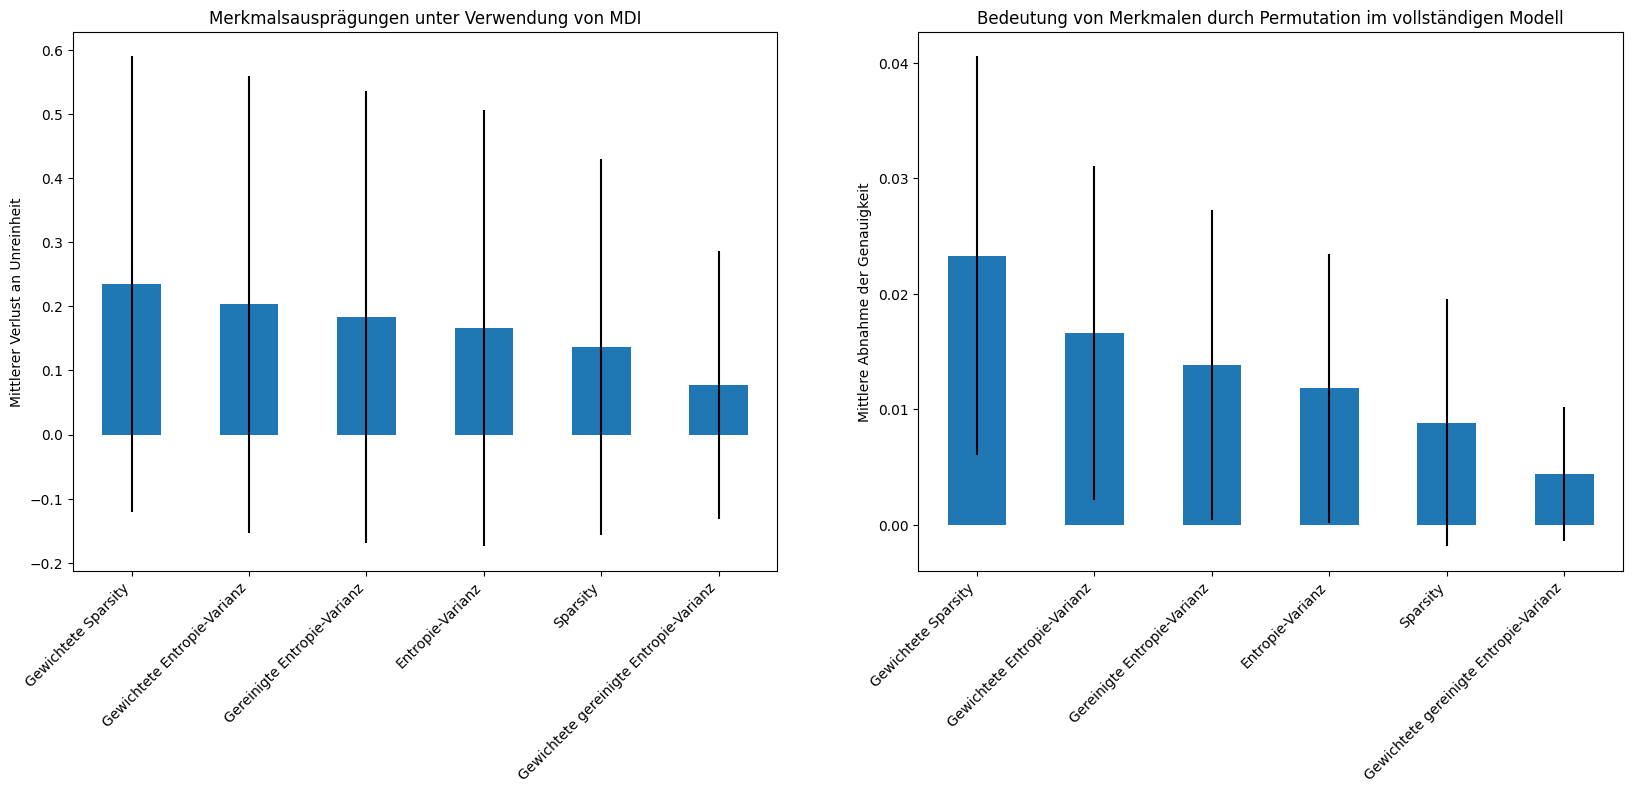

In [469]:
fig=regr_pipeline.plot_importances(X_train_full,y_train_full)
fig.show()

In [224]:
# col = 4
# row = 0

# if col == cols-1:
#     num_pos_c=rows * cols - (len(finetune_datasets)-1)
#     # print(num_pos_c)
#     # print(num_pos_c)
#     for r in range(rows,-1,-1):
#         if r >= (rows+1)-num_pos_c:
#             print(r)
        

In [225]:
len(exp_finetune_datasets[exp]) / 5

3.0

In [502]:
exp_finetune_datasets[exp]

['Clevr-Dist(full)',
 'dSpr-Loc(full)',
 'Caltech101(full)',
 'Resisc45(full)',
 'sNORB-Azim(full)',
 'EuroSAT(full)',
 'SVHN(full)',
 'Pets(full)',
 'DMLab(full)',
 'Sun397(full)',
 'Flowers102(full)',
 'DTD(full)',
 'Retinopathy(full)',
 'sNORB-Elev(full)',
 'CIFAR-100(full)',
 'KITTI-Dist(full)',
 'dSpr-Orient(full)',
 'Clevr-Count(full)',
 'Camelyon(full)']

In [522]:
temp=exp_finetune_datasets[exp]
exp_finetune_datasets[exp]

['Clevr-Dist(full)',
 'dSpr-Loc(full)',
 'Caltech101(full)',
 'Resisc45(full)',
 'sNORB-Azim(full)',
 'EuroSAT(full)',
 'SVHN(full)',
 'Pets(full)',
 'DMLab(full)',
 'Sun397(full)',
 'Flowers102(full)',
 'DTD(full)',
 'Retinopathy(full)',
 'sNORB-Elev(full)',
 'CIFAR-100(full)',
 'KITTI-Dist(full)',
 'dSpr-Orient(full)',
 'Clevr-Count(full)',
 'Camelyon(full)']

In [523]:
# exp_finetune_datasets[exp]=temp

In [532]:
if exp == 'vtab-1':
    exp_finetune_datasets[exp] = ['Caltech101(1000)','CIFAR-100(1000)','Flowers102(1000)','Camelyon(1000)','EuroSAT(1000)','Resisc45(1000)','Clevr-Count(1000)','DMLab(1000)','sNORB-Azim(1000)']
if exp == 'vtab-2-nat':
    exp_finetune_datasets[exp] = ['CIFAR-100(1000)','Caltech101(1000)','Pets(1000)']
if exp == 'vtab-2-spec':
    exp_finetune_datasets[exp] = ['Retinopathy(1000)', 'Resisc45(1000)', 'EuroSAT(1000)']
if exp == 'vtab-2-struc':
    exp_finetune_datasets[exp] = ['Clevr-Count(1000)', 'dSpr-Loc(1000)', 'sNORB-Elev(1000)']
    
if exp == 'vtab-4':
    exp_finetune_datasets[exp] = ['Caltech101(full)','CIFAR-100(full)','Flowers102(full)','Camelyon(full)','EuroSAT(full)','Resisc45(full)','Clevr-Count(full)','DMLab(full)','sNORB-Azim(full)']
# if exp == 'vtab-3-nat':
#     exp_finetune_datasets[exp] = ['Retinopathy(1000)', 'Camelyon(1000)', 'DMLab(1000)']
# if exp == 'vtab-3-spec':
#     exp_finetune_datasets[exp] = ['Retinopathy(1000)', 'Camelyon(1000)', 'DMLab(1000)']

In [533]:
exp_finetune_datasets[exp]

['Caltech101(full)',
 'CIFAR-100(full)',
 'Flowers102(full)',
 'Camelyon(full)',
 'EuroSAT(full)',
 'Resisc45(full)',
 'Clevr-Count(full)',
 'DMLab(full)',
 'sNORB-Azim(full)']

In [534]:
len(exp_finetune_datasets[exp])

9

In [535]:
rows

3

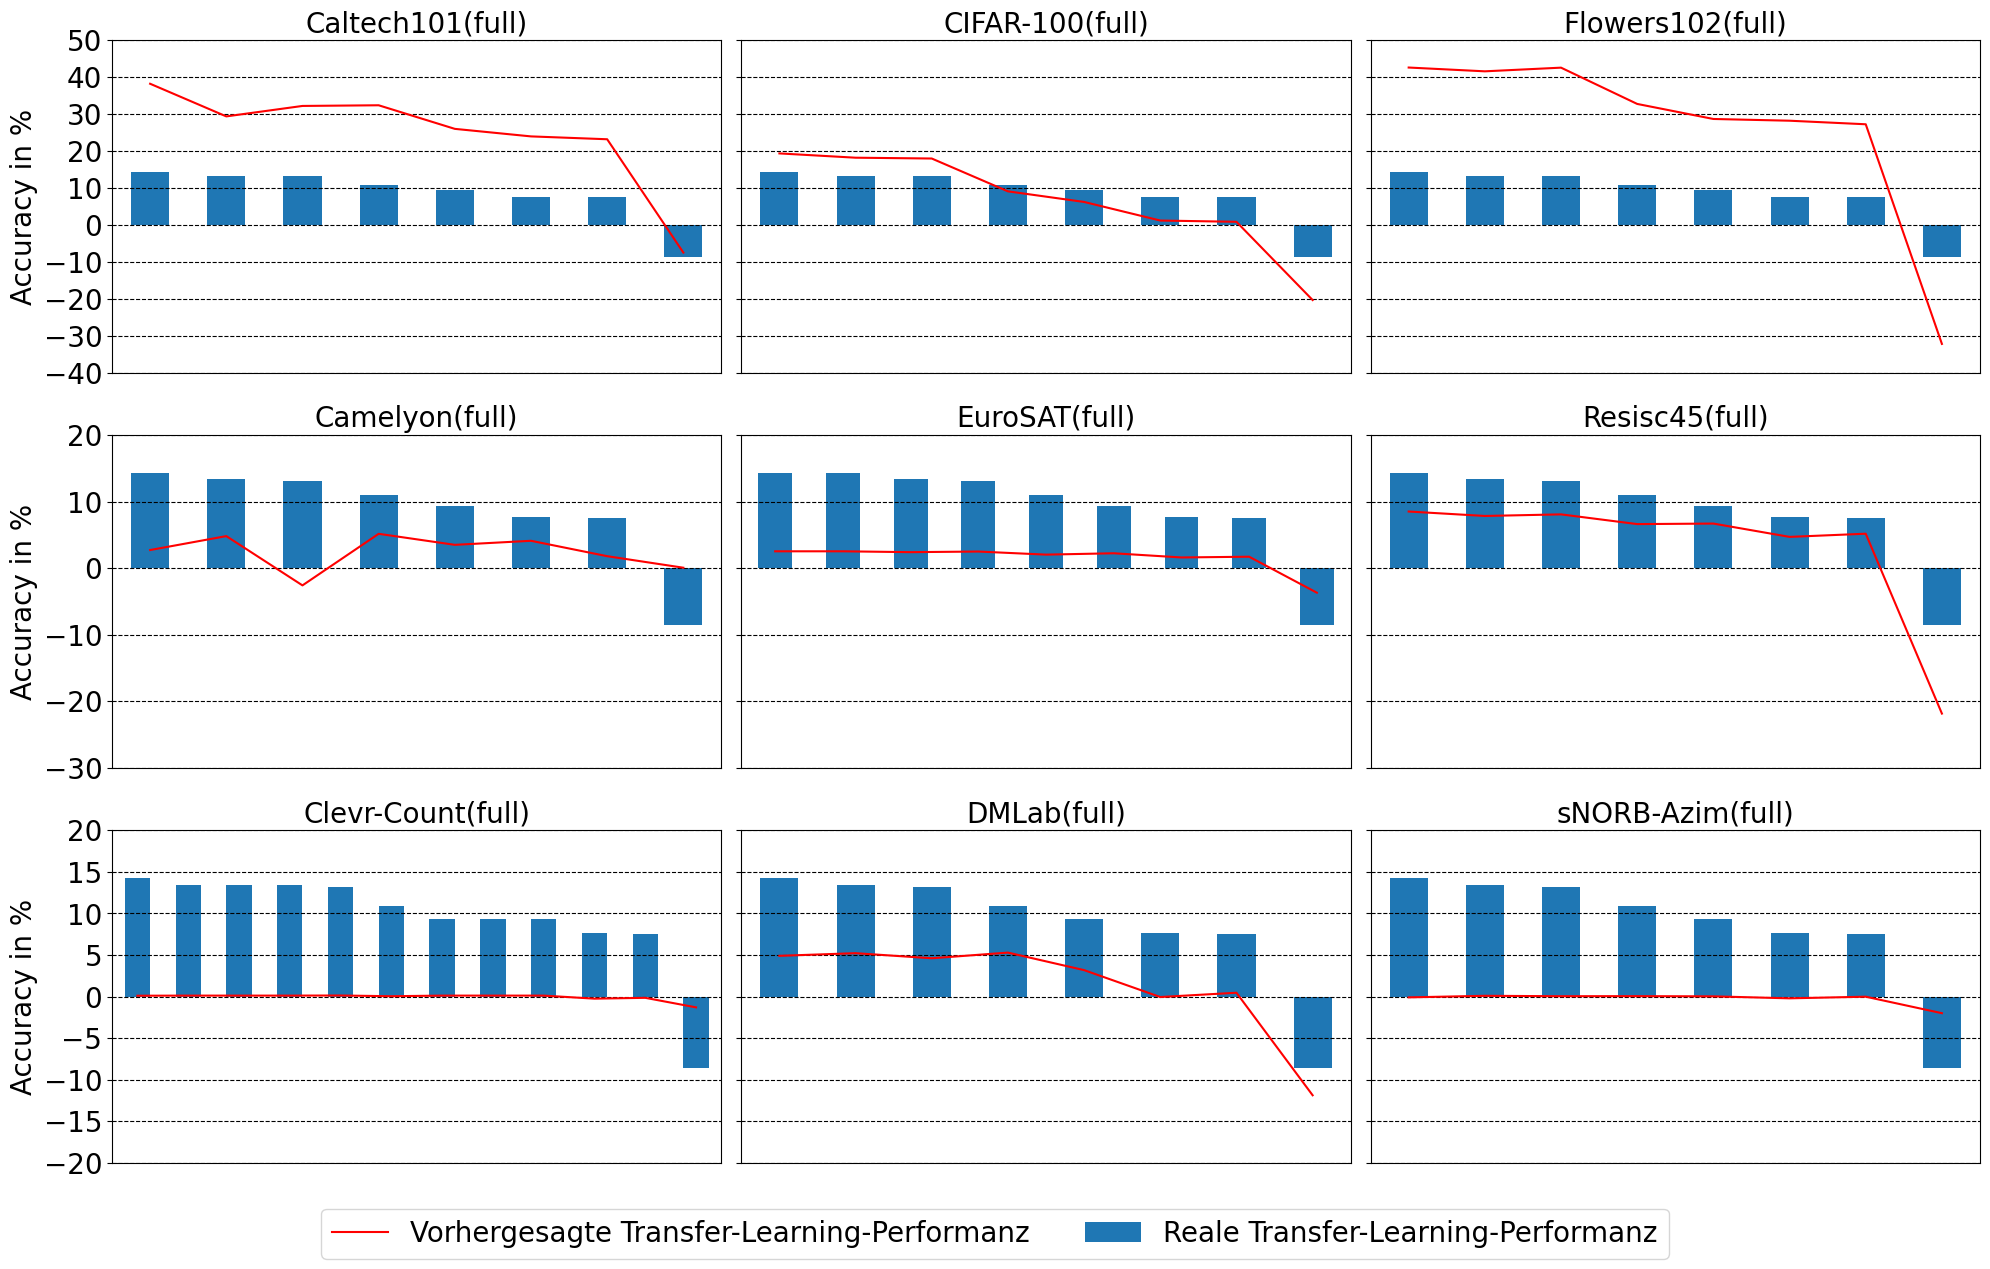

In [536]:
import math
rows_is_one=False
cols = 3
rows = math.ceil(len(exp_finetune_datasets[exp]) / cols) 

if rows == 1:
    rows_is_one=True
    rows=2

# print(finetune_datasets_reshape)
finetune_datasets_reshape=[]
for row in range(rows):
    temp=[]
    for col in range(cols):
        if row*cols+col >= len(exp_finetune_datasets[exp]):
            temp.append("")
        else:
            temp.append(exp_finetune_datasets[exp][row*cols+col])
    finetune_datasets_reshape.append(temp)

# print(finetune_datasets_reshape)
# print(len(exp_finetune_datasets[exp]) % 5)
fig, ax = plt.subplots(rows,cols,figsize=(20,rows*4))

min_ylims = []
max_ylims = []

for row in range(rows):
    for col in range(cols):   
        # print(row,col)
            # print()
        if finetune_datasets_reshape[row][col] == '':
            # if col == cols-1:
            #     num_pos_c=rows * cols - (len(exp_finetune_datasets[exp])-1)
            #     for r in range(rows,-1,-1):
            #         if r >= (rows+1)-num_pos_c:
            #             print(row,col)
            ax[row,col].set_axis_off()
            continue;
        all_pred_dfs[finetune_datasets_reshape[row][col]].sort_values(by="difference_predict", ascending=False)[['finetune_dataset','pretrained_model','difference_predict']].set_index(['finetune_dataset','pretrained_model']).plot.bar(ax=ax[row][col], rot=90,legend=False)
        all_pred_dfs[finetune_datasets_reshape[row][col]].sort_values(by="difference_predict", ascending=False)[['finetune_dataset','pretrained_model','difference']].set_index(['finetune_dataset','pretrained_model']).plot(ax=ax[row][col], rot=90,color="red",legend=False)
        # ax[row,col].set_xlabel(all_predict_dfs[finetune_datasets_reshape[row][col]])
        ax[row][col].set_title(finetune_datasets_reshape[row][col],fontsize=20)
        ax[row][col].get_xaxis().set_visible(False)
        min_ylims.append([])
        max_ylims.append([])
        min_ylims[row].append(ax[row][col].get_ylim()[0])
        max_ylims[row].append(ax[row][col].get_ylim()[1])
        
        
for iax_r, ax_r in enumerate(ax):
    if rows_is_one:
        if iax_r != 0:
            continue;
        
    for iax_c, ax_c in enumerate(ax_r):
        if iax_c != 0:
            ax_c.set_yticklabels([])
        else:
            ax_c.set_ylabel('Accuracy in %',fontsize=20)
        for label in ax_c.get_yticklabels():
            # label.set_fontname('Arial')
            label.set_fontsize(20)
        ax_c.set_ylim(math.floor(min(min_ylims[iax_r])/10)*10,math.ceil(max(max_ylims[iax_r])/10)*10)    
        # print( ax_.get_ylim())
        ax_c.grid(True,color="black",linestyle='--')
        
            # ax[row,col].set_xlabel(ax[row,col].get_xlabel(),rotation=45)
            
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          ncol=2, fancybox=True,labels=['Vorhergesagte Transfer-Learning-Performanz','Reale Transfer-Learning-Performanz'],fontsize=20)
        
# for ax_ in ax:
#     ax_.set_ylim((min(min_ylims),max(max_ylims)))
fig.tight_layout()
if not exp == 'vtab-4':
    fig.savefig(f"../images/vtab_new/reg_exp_vtab_1000_{exp}_{split}.png", bbox_inches='tight')
else:
    fig.savefig(f"../images/vtab_new/reg_exp_vtab_full_{exp}_{split}.png", bbox_inches='tight')
fig.show()

In [283]:
get_finetune_list(X_test_name,'1000')

['SVHN(1000)',
 'Flowers102(1000)',
 'Sun397(1000)',
 'CIFAR-100(1000)',
 'Caltech101(1000)',
 'DTD(1000)',
 'Pets(1000)']

In [284]:
finetune_list_nat

['SVHN(1000)',
 'Flowers102(1000)',
 'Sun397(1000)',
 'CIFAR-100(1000)',
 'Caltech101(1000)',
 'DTD(1000)',
 'Pets(1000)']

In [447]:
X_test_name='structured'
minimized_test_size=True

if minimized_test_size:
    s_l = exp_finetune_datasets[exp]
    finetune_list_nat =get_finetune_list(X_test_name,'1000')
    [finetune_list_nat.remove(l) for l in s_l if l in finetune_list_nat]
    
    X_test_natural = df[df['finetune_dataset'].isin(finetune_list_nat)][features].to_numpy()
    y_test_natural = df[df['finetune_dataset'].isin(finetune_list_nat)][target].to_numpy()
else:
    finetune_list_nat =get_finetune_list(X_test_name,'1000')
    X_test_natural = df[df['finetune_dataset'].isin(finetune_list_nat)][features].to_numpy()
    y_test_natural = df[df['finetune_dataset'].isin(finetune_list_nat)][target].to_numpy()

In [448]:
exp_finetune_datasets[exp]

['Retinopathy(1000)',
 'Resisc45(1000)',
 'EuroSAT(1000)',
 'Camelyon(1000)',
 'SVHN(1000)',
 'Flowers102(1000)',
 'Sun397(1000)',
 'CIFAR-100(1000)',
 'Caltech101(1000)',
 'DTD(1000)',
 'Pets(1000)',
 'DMLab(1000)',
 'KITTI-Dist(1000)']

In [449]:
df_nat=df.copy()
df_nat = df_nat[df_nat['finetune_dataset'].isin(exp_finetune_datasets[exp])]

df_nat['difference_predict']=regr_pipeline.predict(df_nat[features].values)

In [450]:
# df_nat

In [451]:
# predicted_real=np.array(df_nat.sort_values(by="difference_predict", ascending=False)['difference'])
# real=np.array(df_nat.sort_values(by="difference", ascending=False)['difference'])
# # print(predicted_real-real)
# plt.plot(predicted_real-max(real))
# plt.plot(np.array(df_nat.sort_values(by="difference_predict", ascending=False)['difference_predict'])-max(real))

In [452]:
all_pred_dfs_nat={}

for dataset in finetune_list_nat:
    # print(dataset)
    X_test_tmp = df[(df['finetune_dataset'].isin(finetune_list_nat)) & (df['finetune_dataset'] == dataset)][features].to_numpy()
    y_test_tmp = df[(df['finetune_dataset'].isin(finetune_list_nat)) & (df['finetune_dataset'] == dataset)][target].to_numpy()
    all_pred_dfs_nat[dataset]=calculate_predict_diff(regr_pipeline, df, X_test_tmp,y_test_tmp)

In [453]:
get_ranking_error(all_pred_dfs_nat)(finetune_list_nat,c=1)

-24.641907056172688

In [454]:
regr_pipeline.score(X_test_natural,y_test_natural)

-3.127811791664465

In [455]:
mean_squared_error(y_test_natural, regr_pipeline.predict(X_test_natural), squared=False)

20.903970164864557

In [456]:
split = 'test'

if split == 'test':
    finetune_datasets=finetune_list_nat[:3]
if split == 'train':
    finetune_datasets=exp_finetune_datasets[exp][:3]

In [457]:
len(finetune_datasets)

3

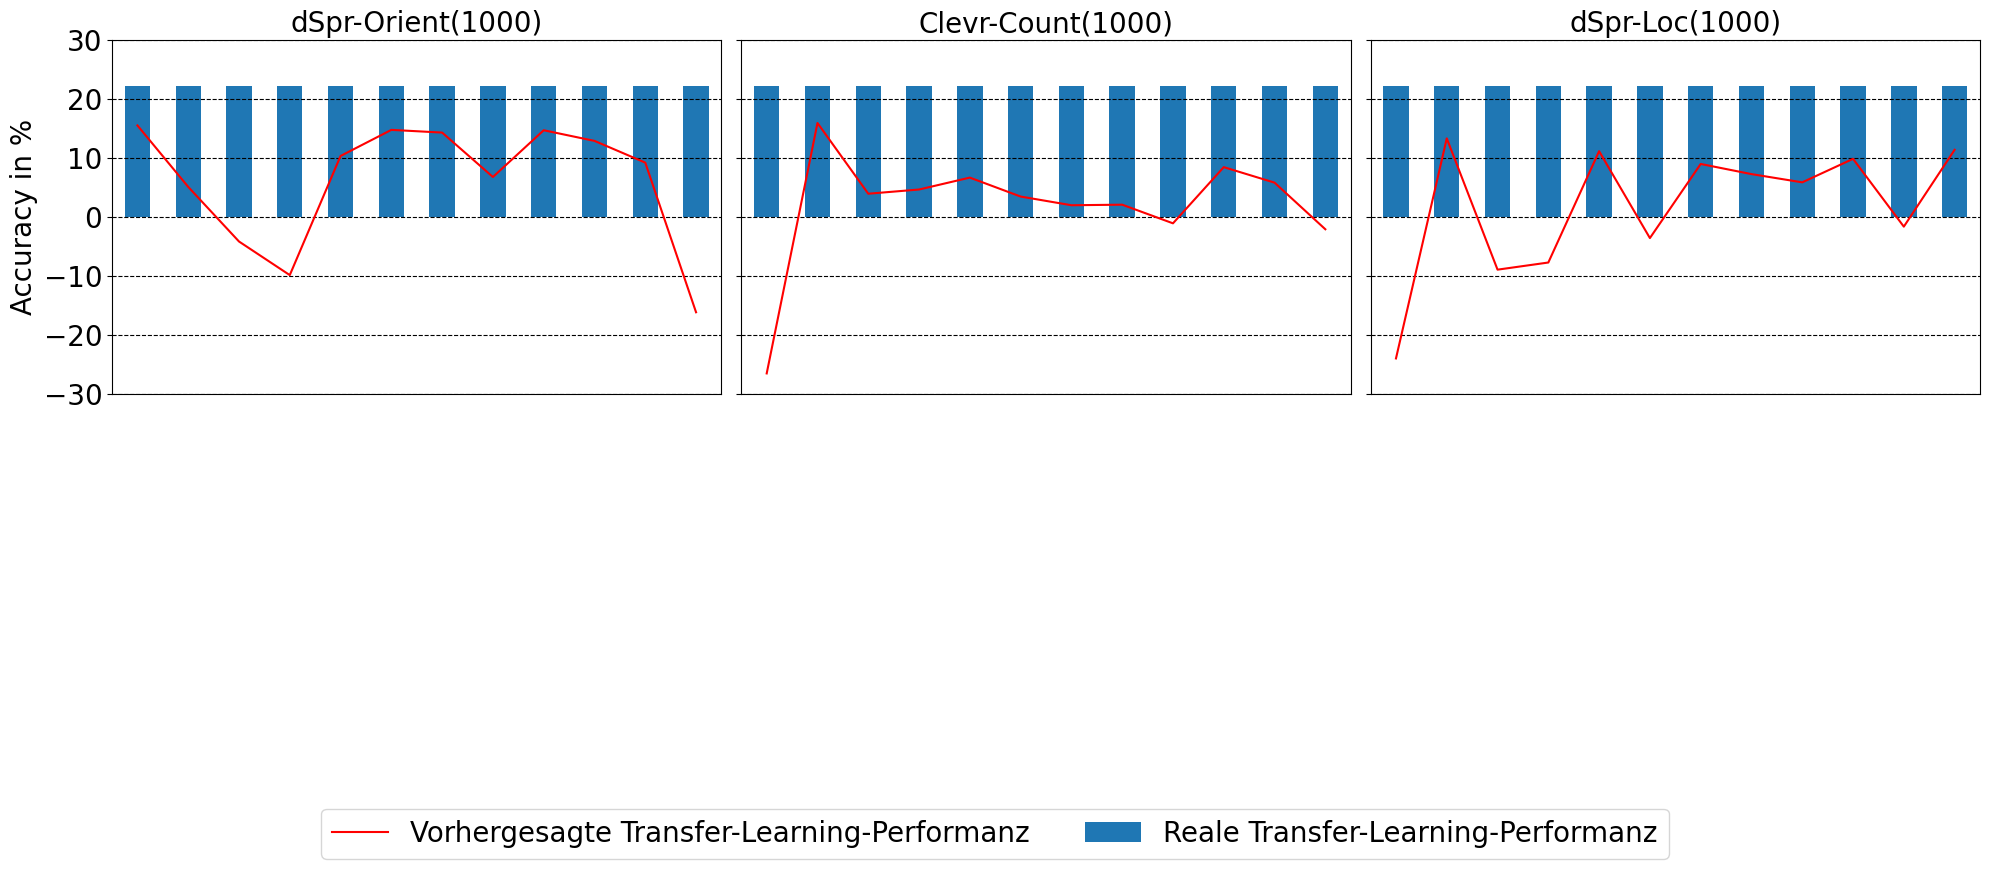

In [458]:
import math
rows_is_one=False
cols = 3
rows = math.ceil(len(finetune_datasets) / cols) 

if rows == 1:
    rows_is_one=True
    rows=2

# print(finetune_datasets_reshape)
finetune_datasets_reshape=[]
for row in range(rows):
    temp=[]
    for col in range(cols):
        if row*cols+col >= len(finetune_datasets):
            temp.append("")
        else:
            temp.append(finetune_datasets[row*cols+col])
    finetune_datasets_reshape.append(temp)

# print(finetune_datasets_reshape)
# print(len(finetune_datasets) % 5)
fig, ax = plt.subplots(rows,cols,figsize=(20,rows*4))

min_ylims = []
max_ylims = []

for row in range(rows):
    for col in range(cols):   
        # print(row,col)
            # print()
        if finetune_datasets_reshape[row][col] == '':
            # if col == cols-1:
            #     num_pos_c=rows * cols - (len(finetune_datasets)-1)
            #     for r in range(rows,-1,-1):
            #         if r >= (rows+1)-num_pos_c:
            #             print(row,col)
            ax[row,col].set_axis_off()
            continue;
        all_pred_dfs_nat[finetune_datasets_reshape[row][col]].sort_values(by="difference_predict", ascending=False)[['finetune_dataset','pretrained_model','difference_predict']].set_index(['finetune_dataset','pretrained_model']).plot.bar(ax=ax[row][col], rot=90,legend=False)
        all_pred_dfs_nat[finetune_datasets_reshape[row][col]].sort_values(by="difference_predict", ascending=False)[['finetune_dataset','pretrained_model','difference']].set_index(['finetune_dataset','pretrained_model']).plot(ax=ax[row][col], rot=90,color="red",legend=False)
        # ax[row,col].set_xlabel(all_predict_dfs[finetune_datasets_reshape[row][col]])
        ax[row][col].set_title(finetune_datasets_reshape[row][col],fontsize=20)
        ax[row][col].get_xaxis().set_visible(False)
        min_ylims.append([])
        max_ylims.append([])
        min_ylims[row].append(ax[row][col].get_ylim()[0])
        max_ylims[row].append(ax[row][col].get_ylim()[1])
        
        
for iax_r, ax_r in enumerate(ax):
    if rows_is_one:
        if iax_r != 0:
            continue;
        
    for iax_c, ax_c in enumerate(ax_r):
        if iax_c != 0:
            ax_c.set_yticklabels([])
        else:
            ax_c.set_ylabel('Accuracy in %',fontsize=20)
        for label in ax_c.get_yticklabels():
            # label.set_fontname('Arial')
            label.set_fontsize(20)
        ax_c.set_ylim(math.floor(min(min_ylims[iax_r])/10)*10,math.ceil(max(max_ylims[iax_r])/10)*10)    
        # print( ax_.get_ylim())
        ax_c.grid(True,color="black",linestyle='--')
        
            # ax[row,col].set_xlabel(ax[row,col].get_xlabel(),rotation=45)
            
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          ncol=2, fancybox=True,labels=['Vorhergesagte Transfer-Learning-Performanz','Reale Transfer-Learning-Performanz'],fontsize=20)
        
# for ax_ in ax:
#     ax_.set_ylim((min(min_ylims),max(max_ylims)))
fig.tight_layout()
if not exp == 'vtab-4':
    fig.savefig(f"../images/vtab_new/reg_exp_vtab_1000_{exp}_{split}.png", bbox_inches='tight')
else:
    fig.savefig(f"../images/vtab_new/reg_exp_vtab_full_{exp}_{split}.png", bbox_inches='tight')
fig.show()